## Practical 3 – Preprocessing, POS Tagging, and Feature Extraction

In [1]:

%pip install -U spacy nltk scikit-learn wordcloud matplotlib seaborn
import sys
import subprocess
subprocess.run([sys.executable, '-m', 'spacy', 'download', 'en_core_web_sm'], check=False)


Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.9 MB/s  0:00:00eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


CompletedProcess(args=['/opt/homebrew/Caskroom/miniforge/base/envs/nlp-class/bin/python', '-m', 'spacy', 'download', 'en_core_web_sm'], returncode=0)

### Part A – Core Tasks

In [2]:

import pandas as pd
from pathlib import Path
from IPython.display import display

DATA_PATH = Path('Spam Data.csv')

df_raw = pd.read_csv(DATA_PATH, encoding='latin-1')
df = (df_raw[['v1', 'v2']]
        .rename(columns={'v1': 'label', 'v2': 'text'}))
df['label'] = df['label'].str.lower()

print(f"Dataset shape: {df.shape}")
display(df.head())

label_counts = df['label'].value_counts().rename_axis('label').to_frame('count')
label_props = df['label'].value_counts(normalize=True).rename_axis('label').to_frame('proportion')

display(label_counts)
display(label_props)


Dataset shape: (5572, 2)


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


,count
label,
ham,4825
spam,747


,proportion
label,
ham,0.865937
spam,0.134063


*Class counts show the dataset is skewed towards ham, so later models must compensate or risk under-serving spam detection.*

In [3]:

import re
import nltk
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

WORDNET_TAG_MAP = {
    'J': wordnet.ADJ,
    'V': wordnet.VERB,
    'N': wordnet.NOUN,
    'R': wordnet.ADV,
}

def map_tag(treebank_tag: str):
    return WORDNET_TAG_MAP.get(treebank_tag[0])


def normalise_message(message: str):
    tokens = word_tokenize(message.lower())
    cleaned = []
    for token, tag in nltk.pos_tag(tokens):
        token = re.sub(r"[^a-z0-9]", "", token)
        if not token or token in stop_words:
            continue
        wn_tag = map_tag(tag)
        lemma = lemmatizer.lemmatize(token, wn_tag) if wn_tag else lemmatizer.lemmatize(token)
        cleaned.append(lemma)
    return cleaned


df['clean_tokens'] = df['text'].apply(normalise_message)
df['clean'] = df['clean_tokens'].apply(lambda toks: ' '.join(toks))

display(df[['label', 'text', 'clean']].head())

all_tokens = [token for tokens in df['clean_tokens'] for token in tokens]
print(f"Vocabulary size after cleaning: {len(set(all_tokens))}")


,label,text,clean
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah nt think go usf live around though


Vocabulary size after cleaning: 7946


*Numbers remain because discount codes can carry signal; dropping punctuation and stopwords keeps the lexicon lean while preserving promo identifiers.*

In [4]:

import spacy

nlp = spacy.load('en_core_web_sm')

sample_text = df.loc[0, 'text']
print('Sample message:', sample_text)
print('NLTK POS tags:')
print(nltk.pos_tag(word_tokenize(sample_text)))

print('spaCy POS tags (token, coarse, fine):')
print([(token.text, token.pos_, token.tag_) for token in nlp(sample_text)])



Sample message: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
NLTK POS tags:
[('Go', 'NNP'), ('until', 'IN'), ('jurong', 'JJ'), ('point', 'NN'), (',', ','), ('crazy', 'JJ'), ('..', 'NN'), ('Available', 'NNP'), ('only', 'RB'), ('in', 'IN'), ('bugis', 'NN'), ('n', 'RB'), ('great', 'JJ'), ('world', 'NN'), ('la', 'NN'), ('e', 'FW'), ('buffet', 'NN'), ('...', ':'), ('Cine', 'NNP'), ('there', 'EX'), ('got', 'VBD'), ('amore', 'RB'), ('wat', 'NN'), ('...', ':')]
spaCy POS tags (token, coarse, fine):
[('Go', 'VERB', 'VB'), ('until', 'ADP', 'IN'), ('jurong', 'PROPN', 'NNP'), ('point', 'PROPN', 'NNP'), (',', 'PUNCT', ','), ('crazy', 'ADJ', 'JJ'), ('..', 'PUNCT', '.'), ('Available', 'ADJ', 'JJ'), ('only', 'ADV', 'RB'), ('in', 'ADP', 'IN'), ('bugis', 'PROPN', 'NNP'), ('n', 'X', 'FW'), ('great', 'ADJ', 'JJ'), ('world', 'NOUN', 'NN'), ('la', 'ADP', 'IN'), ('e', 'PROPN', 'NNP'), ('buffet', 'PROPN', 'NNP'), ('...', 'PUNCT', ':'), ('Cine'

*spaCy preserves multi-token context (e.g. compound nouns) better than NLTK's tagger, which leans on per-token heuristics.*

In [5]:

TARGET_TAGS = {'NN', 'NNS', 'JJ', 'JJR', 'JJS'}

def filter_pos(text: str):
    doc = nlp(text)
    return [token.text for token in doc if token.tag_ in TARGET_TAGS]


df['filtered_tokens'] = df['clean'].apply(filter_pos)
df['filtered_text'] = df['filtered_tokens'].apply(lambda toks: ' '.join(toks))

display(df[['clean', 'filtered_text']].head())
print('Mean filtered length:', df['filtered_tokens'].apply(len).mean())


,clean,filtered_text
0,go jurong point crazy available bugis n great ...,point available great world wat
1,ok lar joke wif u oni,lar joke oni
2,free entry 2 wkly comp win fa cup final tkts 2...,free entry wkly comp win final tkts 21st text ...
3,u dun say early hor u c already say,early hor u
4,nah nt think go usf live around though,usf


Mean filtered length: 4.110911701363963


*Focusing on nouns and adjectives sharpens topic descriptors whilst trimming filler; ideal for feature spaces geared towards intent and objects.*

In [6]:

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

bow_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=2)
bow_matrix = bow_vectorizer.fit_transform(df['clean'])
features = bow_vectorizer.get_feature_names_out()

print('BoW shape:', bow_matrix.shape)
print('First 20 features:', features[:20])

feature_totals = bow_matrix.sum(axis=0).A1
top_indices = np.argsort(feature_totals)[::-1][:40]
top_features = [(features[i], int(feature_totals[i])) for i in top_indices]

top_features_df = pd.DataFrame(top_features, columns=['feature', 'count'])
display(top_features_df.head(20))


BoW shape: (5572, 9497)
First 20 features: ['008704050406' '008704050406 sp' '01223585334' '01223585334 cum' '020603'
 '020603 2nd' '0207' '0207 153' '02073162414' '02073162414 cost' '020903'
 '020903 2nd' '021' '050703' '050703 csbcm4235wc1n3xx' '0578' '071104'
 '07123456789' '07123456789 87077' '07734396839']


,feature,count
0,get,700
1,call,658
2,go,555
3,ur,385
4,nt,377
5,come,326
6,gt,318
7,lt,316
8,know,286
9,ok,284


*High-frequency bigrams like “call now” and “free entry” flag spam-promotional phrasing; skimming beyond the first 20 confirms recurring offer language.*

In [7]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean'])

feature_names = tfidf_vectorizer.get_feature_names_out()
weights = tfidf_matrix.sum(axis=0).A1
ranked_idx = np.argsort(weights)[::-1][:30]
ranked_features = [(feature_names[i], weights[i]) for i in ranked_idx]

tfidf_df = pd.DataFrame(ranked_features, columns=['feature', 'tfidf_weight'])
display(tfidf_df.head(20))
print('TF-IDF matrix shape:', tfidf_matrix.shape)


,feature,tfidf_weight
0,call,77.101379
1,get,75.072844
2,ok,69.123329
3,go,63.292398
4,come,52.202816
5,nt,44.285852
6,ur,40.856369
7,gt,40.658573
8,lt,40.350529
9,good,39.170631


TF-IDF matrix shape: (5572, 38312)


*Terms combining exclusivity with urgency earn higher TF-IDF weights because they surge in spam yet stay rare in ham, making them potent discriminators.*

### Part B – Extended Tasks

In [8]:

filtered_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
filtered_matrix = filtered_vectorizer.fit_transform(df['filtered_text'])

print('Full TF-IDF shape:', tfidf_matrix.shape)
print('POS-filtered TF-IDF shape:', filtered_matrix.shape)

filtered_weights = filtered_matrix.sum(axis=0).A1
filtered_names = filtered_vectorizer.get_feature_names_out()
filtered_rank = np.argsort(filtered_weights)[::-1][:20]
filtered_features = [(filtered_names[i], filtered_weights[i]) for i in filtered_rank]

display(pd.DataFrame(filtered_features, columns=['feature', 'tfidf_weight']))


Full TF-IDF shape: (5572, 38312)
POS-filtered TF-IDF shape: (5572, 17139)


,feature,tfidf_weight
0,time,60.707199
1,good,55.946617
2,call,54.948919
3,day,46.320013
4,free,43.997785
5,sorry,42.652220
6,today,40.497863
7,text,39.624155
8,home,36.982802
9,dear,33.128723


*Restricting to nouns/adjectives shrinks dimensionality substantially, producing features centred on products and descriptors rather than functional glue words.*

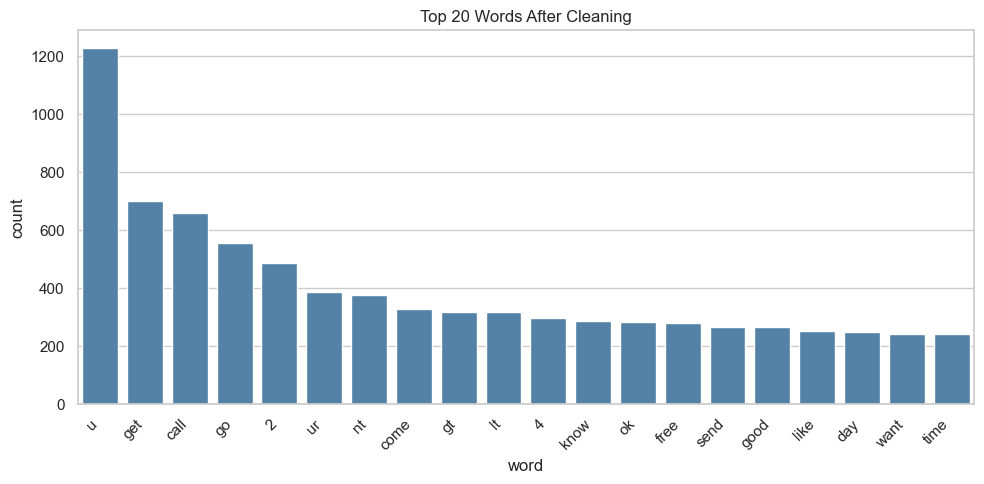

In [9]:

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

word_counts = Counter(all_tokens)
common_words = word_counts.most_common(20)
common_df = pd.DataFrame(common_words, columns=['word', 'count'])

plt.figure(figsize=(10, 5))
sns.barplot(data=common_df, x='word', y='count', color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Words After Cleaning')
plt.tight_layout()
plt.show()


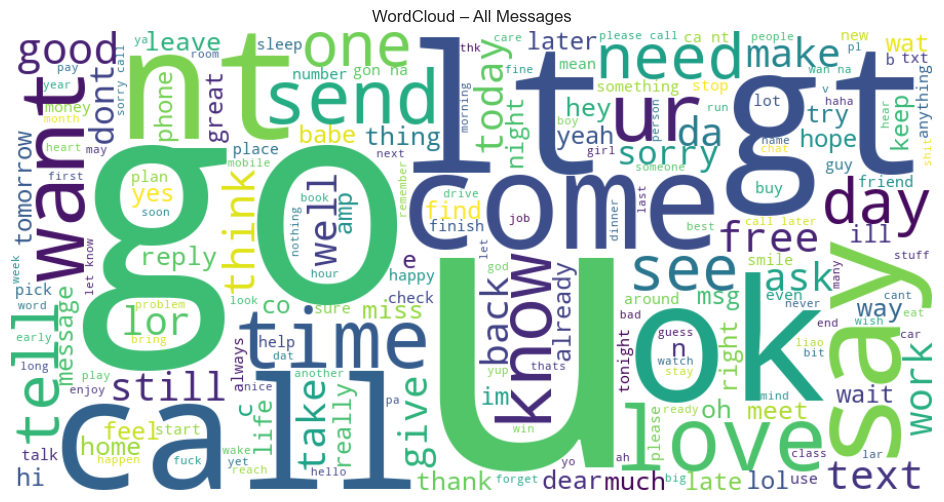

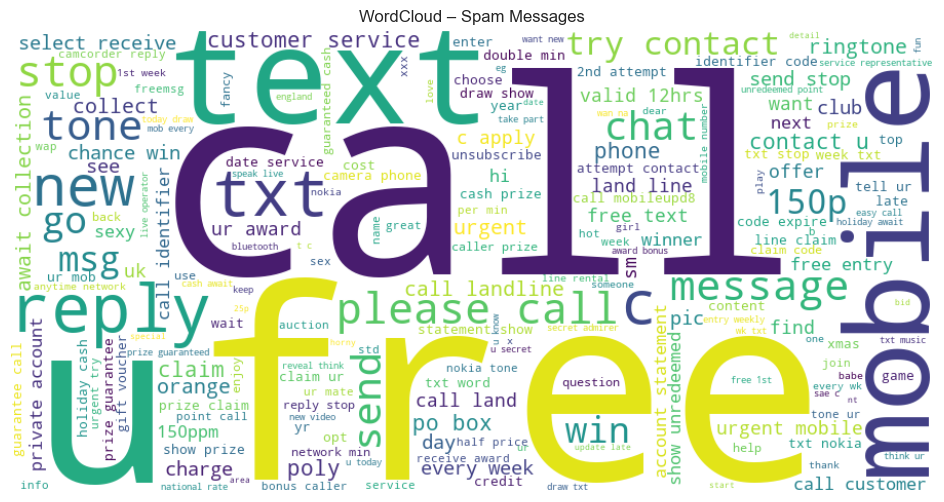

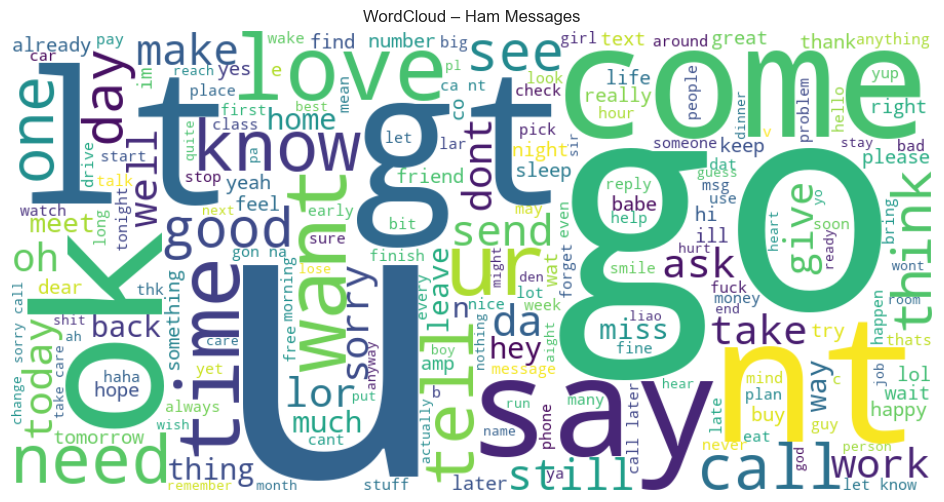

In [10]:

from wordcloud import WordCloud

joined_clean = ' '.join(df['clean'])
wc_all = WordCloud(width=900, height=450, background_color='white').generate(joined_clean)

plt.figure(figsize=(12, 6))
plt.imshow(wc_all, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud – All Messages')
plt.show()

for label in ['spam', 'ham']:
    text_blob = ' '.join(df.loc[df['label'] == label, 'clean'])
    wc = WordCloud(width=900, height=450, background_color='white').generate(text_blob)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud – {label.capitalize()} Messages')
    plt.show()


*Spam clouds brim with monetary hooks (“call”, “free”, “win”), signalling persuasive tone; ham clouds stay conversational with daily logistics.*


### Q8 – Fairness and Bias Reflection
- **Class imbalance**: A ham-heavy training set biases classifiers toward negative predictions, so spam slips through unless we rebalance or tune thresholds.
- **Dialect and slang**: Stripping vernacular tokens can silence communities and reduce recall on legitimate ham written in dialects.
- **Documentation**: Log preprocessing choices (stopwords, regexes, POS filters) in a model card or data sheet so stakeholders can audit linguistic exclusions.



### Q9 – Extended Reflection
- **POS utility**: Tagging steers feature selection toward semantically rich tokens, trimming the noise of auxiliary verbs.
- **BoW vs TF-IDF**: BoW boosts frequent terms, whereas TF-IDF suppresses ubiquitous words so rare-yet-informative tokens stand out.
- **Impactful preprocessing**: Decisions around lemmatisation, stopword scope, and digit handling sway downstream accuracy the most.
- **Cleaning bias**: Over-aggressive normalisation can erase cultural markers and skew predictions toward dominant language norms.
- **Pipeline link**: The practical mirrors the lecture pipeline: ingest → clean → annotate (POS) → featurise (BoW/TF-IDF) → analyse.
